#### GDN with MC-Dropout
Gal et al.

In [6]:
import sys
import os
import time
import argparse
import pdb

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Add higher directory to python modules path.
sys.path.append("..") 
from dataloader import load_cora
from model import GCN

In [52]:
class obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
               setattr(self, a, [obj(x) if isinstance(x, dict) else x for x in b])
            else:
               setattr(self, a, obj(b) if isinstance(b, dict) else b)
args = {
    'gpu': 1,
    'seed': None,
    'epochs': 500,
    'lr': 0.01,
    'wd': 5e-4,
    'layers': 2,
    'h_size': 16,
    'dropout': 0.5,
    'val_every': -1,
    'val_only': 1,
    'checkpoint': 0, 
    'model': '../save/model-val-0.8200.pth', 
    'log_every': 50,
    'prepro': '../../data/cora/preprocessed.pth',
    'test': 0,
}
args = obj(args)

In [53]:
# Setup
start = time.time()
args.gpu = args.gpu and torch.cuda.is_available() and False
if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)

# Data
if args.prepro:
    tmp = torch.load(args.prepro)
    adj_i, adj_v, adj_s, feats, labels, idx_train, idx_val, idx_test = tmp
    adj = torch.sparse.FloatTensor(adj_i, adj_v, adj_s)
else:
    adj, feats, labels, idx_train, idx_val, idx_test = load_cora()

In [54]:
# Model
model = GCN(num_layers=args.layers, 
            in_size=feats.shape[1],
            h_size=args.h_size, 
            out_size=labels.max().item() + 1,
            dropout=args.dropout,
            mc_dropout=True)
if args.model:
    model.load_state_dict(torch.load(args.model))

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)

# GPU
if args.gpu:
    tmp = model, adj, feats, labels, idx_train, idx_val, idx_test
    tmp = [x.cuda() for x in tmp]
    model, adj, feats, labels, idx_train, idx_val, idx_test = tmp

In [ ]:
import torch.nn.functional as F 

# Validation: average over samples
model.eval()
total = 0
num_samples = 100
for i in range(num_samples):
    output = model(feats, adj)
    idx = idx_val # helper
    y_hat, y = (output[idx], labels[idx]) # helper
    loss = F.cross_entropy(y_hat, y)
    preds = y_hat.max(1)[1].type_as(y)
    preds_eq = preds.eq(y)
    acc = preds_eq.float().sum() / len(y)
    total += acc    
print(total / num_samples)

#### Exploring
We explore the degree of uncertainty given to the incorrectly labeled data points. 

In [33]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)

In [19]:
# Extract incorrect labels
idx = idx_val
y_hat_wrong = torch.nn.functional.softmax(output[idx][preds_eq == 0], dim=1)
y_wrong = labels[idx][preds_eq == 0]
y_wrong_onehot = torch.eye(7)[labels[idx][preds_eq == 0]]

In [31]:
# Some example data points
print('--- Example 53') #index 493 in original data set
print('Prediction: ', y_hat_wrong[53].data.numpy())
print('Label: ', y_wrong[53].item())
print()
print('--- Example 33')
print('Prediction: ', y_hat_wrong[33].data.numpy())
print('Label: ', y_wrong[33].item())

--- Example 53
Prediction:  [0.0038336  0.0264072  0.00794656 0.00600775 0.02236747 0.88942635
 0.04401103]
Label:  1

--- Example 33
Prediction:  [0.10840377 0.07533472 0.06667564 0.0504989  0.16540006 0.37090844
 0.1627784 ]
Label:  0


(array([13., 13., 14.,  3.,  1.,  3.,  0.,  1.,  2.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([0.00322671, 0.04686362, 0.09050052, 0.13413742, 0.17777433,
        0.22141123, 0.26504812, 0.30868503, 0.35232192, 0.39595884,
        0.43959573, 0.48323265, 0.52686954, 0.57050645, 0.6141434 ,
        0.65778023, 0.70141715, 0.74505407, 0.788691  , 0.83232784,
        0.87596476], dtype=float32),
 <a list of 20 Patch objects>)

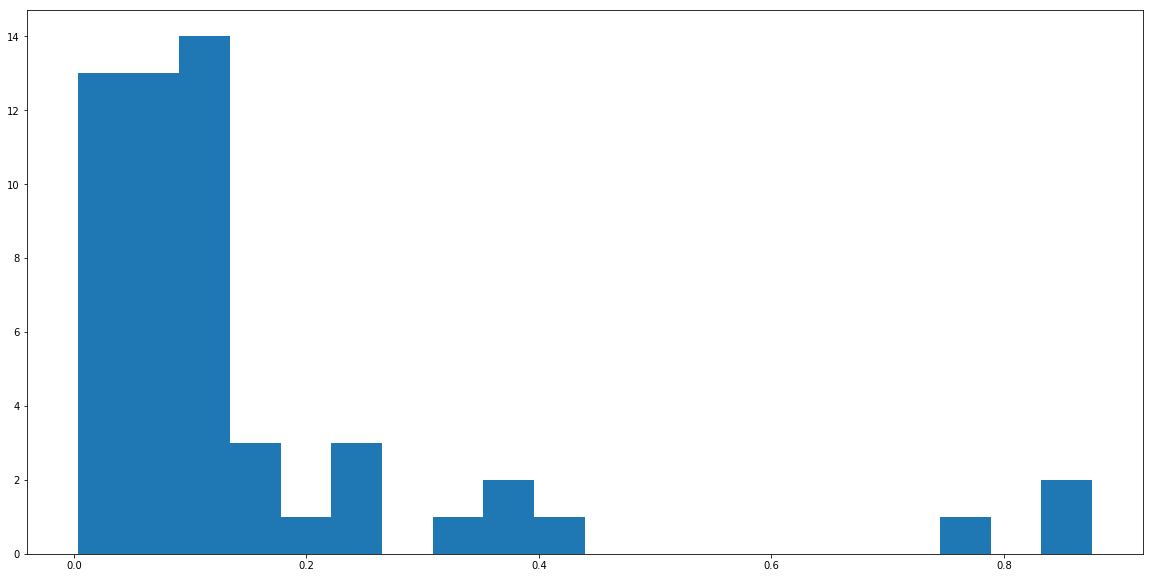

In [34]:
# The amount we are wrong for each example: 
# max predicted (wrong) class probability - the correct class probability
amt_wrong = y_hat_wrong.max(dim=1)[0] - (y_wrong_onehot * y_hat_wrong).sum(dim=1)
plt.hist(amt_wrong.detach().cpu().numpy(), bins=20)